<a href="https://colab.research.google.com/github/shivendrra/SmallLanguageModel-project/blob/main/FullScaleSLM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Full Scale Small Language Model
by @shivendrra

In [ ]:
from google.colab import files
channelData = files.upload()

In [ ]:
channel_Id_Json  = [
  "UCA19mAJURyYHbJzhfpqhpCA",
  "UCsXVk37bltHxD1rDPwtNM8Q",
  "UCRcgy6GzDeccI7dkbbBna3Q",
  "UCmGSJVG3mCRXVOP4yZrU1Dw",
  "UC415bOPUcGSamy543abLmRA",
  "UCb_MAhL8Thb3HJ_wPkH3gcw",
  "UC9RM-iSvTu1uPJb8X5yp3EQ",
  "UCR1IuLEqb6UEA_zQ81kwXfg",
  "UCYO_jab_esuFRV4b17AJtAw",
  "UCA295QVkf9O1RQ8_-s3FVXg",
  "UCqVEHtQoXHmUCfJ-9smpTSg",
  "UC4QZ_LsYcvcq7qOsOhpAX4A",
  "UCLXo7UDZvByw2ixzpQCufnA"
]

In [ ]:
!pip install python-dotenv
!pip install youtube-transcript-api

In [ ]:
import json
from dotenv import load_dotenv
import os

load_dotenv()
api_key = os.getenv('yt_secret_key')

In [ ]:
from googleapiclient.discovery import build
from youtube_transcript_api import TranscriptsDisabled, YouTubeTranscriptApi
import logging

logging.basicConfig(filename='youtube_fetch.log', level=logging.ERROR)
youtube = build('youtube', 'v3', developerKey=api_key)

In [ ]:
import timeit

start_time = timeit.default_timer()

videoNo = 0
for links in channel_Id_Json:
  next_page_token = None
  videoIds = []

  while True:
    channelRes = youtube.channels().list(
      part='contentDetails', id=links
    ).execute()

    if 'items' in channelRes and channelRes['items']:
      playlistId = channelRes['items'][0]['contentDetails']['relatedPlaylists']['uploads']

      playlistResult = youtube.playlistItems().list(
        part='contentDetails', playlistId=playlistId,
        maxResults = 100, pageToken = next_page_token
      ).execute()

      videoIds.extend([item['contentDetails']['videoId'] for item in playlistResult.get('items', [])])

      next_page_token = playlistResult.get('nextPageToken')

      if not next_page_token:
        break

  for ids in videoIds:
    videoUrl = f"https://www.youtube.com/watch?v={ids}"
    try:
      raw_transcripts = []
      try:
        captions = YouTubeTranscriptApi.get_transcript(
          ids, languages=['en'], preserve_formatting=True
        )
        if captions:
          formatted_captions = [{'text': caption['text']} for caption in captions]
          raw_transcripts.append(formatted_captions)
          videoNo += 1
          print(f"Number of videos with valid captions are: {videoNo}")
        else:
          continue
      except TranscriptsDisabled as e:
        print(F"There was an error while getting the captions: {e}")
      except Exception as e:
        logging.error(f"There was some error while fetching the video: {str(e)}")
    except Exception as e:
      logging.error(f"There was some error while getting the captions: {str(e)}")

    with open('training_data.txt', 'a', encoding='utf-8') as file:
      for videoCaptions in raw_transcripts:
        for line in videoCaptions:
          file.write(line['text'] + ' ')

print(f"time taken to execute the code is {timeit.default_timer() - start_time} mins")

In [1]:
with open('training_data.txt', 'r', encoding='utf-8') as file:
  captions = file.read()

In [2]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer, PorterStemmer
ps = PorterStemmer()
lm = WordNetLemmatizer()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [28]:
sent_token = nltk.sent_tokenize(captions)
print(sent_token[10])

Something that would represent kurzgesagt’s   view of the world and our belief in 
humanity’s potential for greatness.


In [33]:
for i in sent_token:
  tokens = nltk.word_tokenize(i)
  lemmatized_tokens = [lm.lemmatize(token.lower()) for token in tokens if token.isalpha()]

In [57]:
# Applying tf-idf
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer()
tfidf_matrix = tfidf.fit_transform(lemmatized_tokens).toarray()

In [58]:
print(len(tfidf_matrix))

33


In [59]:
# converting the vectors to .csv and then saving it
import pandas as pd

vector_array = pd.DataFrame(tfidf_matrix)
vector_array.to_csv('vector_data.csv')

print('data written to .csv file successfully!!')
# print(f"Data vectorized in : {timeit.default_timer() - start_time} mins")

data written to .csv file successfully!!


In [60]:
dataset = pd.read_csv('vector_data.csv')
print(type(dataset))

<class 'pandas.core.frame.DataFrame'>


In [67]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import time

start_time = time.time()

class CustomDataset(Dataset):
    def __init__(self, csv_file):
        self.data = pd.read_csv(csv_file)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = {'input': torch.FloatTensor(self.data.iloc[idx, :-5].values),
                  'target': torch.FloatTensor([self.data.iloc[idx, -5]])}
        return sample

class TransformerModel(nn.Module):
    def __init__(self, input_size, output_size, d_model=64, nhead=2, num_layers=2):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Linear(input_size, d_model)
        self.transformer = nn.Transformer(d_model, nhead, num_layers)
        self.fc = nn.Linear(d_model, output_size)

    def forward(self, x):
        x = self.embedding(x)
        x = x.unsqueeze(0)

        # Apply transformer
        x = self.transformer(x, x)
        x = x.squeeze(0)
        x = torch.mean(x, dim=0)
        x = self.fc(x)
        return x

dataset = CustomDataset('vector_data.csv')
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# model
input_size = dataset[0]['input'].shape[0]
output_size = dataset[0]['target'].shape[0]
model = TransformerModel(input_size, output_size)

# loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 100
losses = []

for epoch in range(num_epochs):
    epoch_losses = []

    for batch in dataloader:
        inputs, targets = batch['input'], batch['target']

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        epoch_losses.append(loss.item())

    average_epoch_loss = np.mean(epoch_losses)
    losses.append(average_epoch_loss)

    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {average_epoch_loss}')

end_time = start_time - time.time()
print('\n', f"Code executed in {end_time / 60} mins")

torch.save(model.state_dict(), 'transformer_model.pth')

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([1, 1])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the

Epoch 1/100, Loss: 4.443864047527313
Epoch 2/100, Loss: 1.5579406023025513
Epoch 3/100, Loss: 0.3652389645576477
Epoch 4/100, Loss: 0.29687606915831566
Epoch 5/100, Loss: 0.073617834597826
Epoch 6/100, Loss: 0.19278176873922348
Epoch 7/100, Loss: 0.04913720874553107
Epoch 8/100, Loss: 0.02273709373548627
Epoch 9/100, Loss: 0.01979414909146726
Epoch 10/100, Loss: 0.03465003566816449
Epoch 11/100, Loss: 0.027271769009530544
Epoch 12/100, Loss: 0.06604825705289841
Epoch 13/100, Loss: 0.015247741524945013
Epoch 14/100, Loss: 0.06464808806777
Epoch 15/100, Loss: 0.04653896111994982
Epoch 16/100, Loss: 0.021390523795162153
Epoch 17/100, Loss: 0.019155686488375068
Epoch 18/100, Loss: 0.05180709436535835
Epoch 19/100, Loss: 0.11360288225114346
Epoch 20/100, Loss: 0.047052159905433655
Epoch 21/100, Loss: 0.025042245164513588
Epoch 22/100, Loss: 0.04250383656471968
Epoch 23/100, Loss: 0.01949952752329409
Epoch 24/100, Loss: 0.0159996617003344
Epoch 25/100, Loss: 0.02052756278135348
Epoch 26/100,

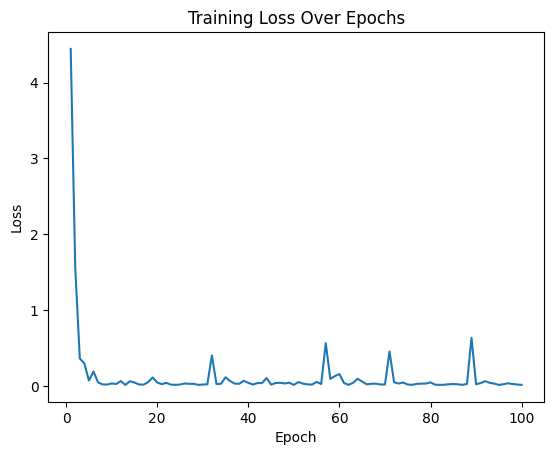

In [68]:
import matplotlib.pyplot as plt

plt.plot(range(1, num_epochs + 1), losses)
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(False)
plt.show()